# Segmenting and Clustering Neighborhoods in Toronto

Capstone Coursera **IBM Data Science** specialization, assignment week 3.

Use data on Canadian postal codes from Wikipedia to distinguish boroughs and neighbourhoods in Toronto,
use a geocoding service to assign coordinates to them, use Foursquare to determine what kinds of venues
are present in each neighbourhood, and finally apply clustering and visualization to explore distinctions and similarities between neighbourhoods.

For the sake of the assignment, this document consists of three parts:
1. [Get data on boroughs and neighbourhoods in Toronto](#Part-1:-Get-data-on-boroughs-and-neighbourhoods-in-Toronto)
2. [Add locations (latitude, longitude coordinates) to neighbourhoods](#Part-2:-Add-locations)
3. [Explore and cluster the neighbourhoods of Toronto](#Part-3:-Explore-and-cluster-the-neighborhoods-in-Toronto)

## Basic imports
Before getting started we import a number of python modules that we will use later.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# !pip3 install geocoder==0.6.0
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# Part 1: Get data on boroughs and neighbourhoods in Toronto

In this part we:
* Read the data on the relation between postal codes, boroughs, and neighbourhoods in Toronto
* Clean the data up for further processing

## Read the data

The postal codes of Toronto in the province of Ontario are those beginnig with M. They can be found at:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

1. Use pandas's read_html to get a *list* of dataframes on the wikipedia page
2. Check to see which is the one we are looking for and select this one for further processing

In [2]:
# Pandas needs LXML to read HTML. If it is not present, first install it.
# !pip3 install lxml
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# The first row (index=0) of the table contains the headers
list_of_dataframes = pd.read_html(url, header=0)

In [3]:
# As read_html returns a *list* of dataframes, we should first see which is the one we are looking for
for i, df in enumerate(list_of_dataframes):
    print('----- index', i, '-----')
    print(df.head())

----- index 0 -----
  Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
----- index 1 -----
                                          Unnamed: 0  \
0  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...   
1                                                 NL   
2                                                  A   

                               Canadian postal codes  \
0  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...   
1                                                 NS   
2                                                  B   

                                          Unnamed: 2 Unnamed: 3 Unnamed: 4  \
0  NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...        NaN        NaN   
1                                                 PE         NB         

We see that the first dataframe in the list is the right one, so we select it.

In [4]:
toronto_neighbourhoods = list_of_dataframes[0]
toronto_neighbourhoods.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Ok, we now have the wikipedia page data in a dataframe. For the sake of the assignment, rename the 'Postcode' column to 'Postal Code'.

In [5]:
toronto_neighbourhoods.rename(columns={"Postcode": "Postal Code"}, inplace=True)

# For reference display its current shape
toronto_neighbourhoods.shape

(287, 3)

## Clean up the data
* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

### Ignore cells with a borough that is 'Not assigned'

In [6]:
toronto_neighbourhoods.drop(
    toronto_neighbourhoods[toronto_neighbourhoods['Borough'] == 'Not assigned'].index,
    inplace=True
)

### If a neighbourhooed is 'Not assigned', give it the value of the borough 

In [7]:
mask = toronto_neighbourhoods['Neighbourhood'] == 'Not assigned'
toronto_neighbourhoods['Neighbourhood'] = np.where(
    mask,
    toronto_neighbourhoods['Borough'], 
    toronto_neighbourhoods['Neighbourhood'])
toronto_neighbourhoods.head(10)

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Queen's Park,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


### Concatenate neighbourhoods that have the same Postcode

If different neighbourhoods have the same Postcode, merge them into a single neighbourhood by concatening their names.

In [8]:
toronto_neighbourhoods = toronto_neighbourhoods.groupby(
    ['Postal Code','Borough'])['Neighbourhood'].apply(lambda x: ','.join(x)).reset_index()
toronto_neighbourhoods.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Check up: Toronto neighbourhoods dataframe shape

In [9]:
toronto_neighbourhoods.shape

(103, 3)

# Part 2: Add locations

### Plan A: Read locations of postal codes by geocoder service

This an implementation according to the assignment instructions. It doesn't work as
the service consistently returns a **REQUEST DENIED** error. The implementation is given here 
for completeness. Actual data is - conform assignment instructions - read from a provided CSV file.

In [10]:
def get_ll_geocode(postcodes):
    # initialize your variable to None
    lat_lng_coords = None
    d = {'Postal Code': [], 'Latitude': [], 'Longitude': []}
    for postal_code in postcodes:
        # loop until you get the coordinates
        while(lat_lng_coords is None):
            # This call consistently gives me a REQUEST DENIED error
            #g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
            #lat_lng_coords = g.latlng
            lat_lng_coords = (43.653963, -79.387207)

        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        d['Postal Code'].append(postal_code)
        d['Latitude'].append(latitude)
        d['Longitude'].append(longitude)
    return pd.DataFrame(d)

In [11]:
# Call the above method
# As it results in REQUEST DENIED errors it is here commented out
# postcodes_locations = get_ll_geocode(toronto_neighbourhoods['Postcode'])

### Plan B: read locations of postal codes from online CSV file

Use data placed online to facilitate this course: https://cocl.us/Geospatial_data

In [12]:
postcodes_locations = pd.read_csv('https://cocl.us/Geospatial_data')
postcodes_locations.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Join the neighbourhood dataframe with the locations dataframe.

In [13]:
neighbourhoods = pd.merge(toronto_neighbourhoods, postcodes_locations, how='left', on='Postal Code')
neighbourhoods.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Finally we can drop the 'Postal Code' column, as we don't need it any more. 
And Americanize the spelling of neighbourhood.

In [14]:
neighbourhoods.drop('Postal Code', axis=1, inplace=True)
neighbourhoods.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace=True)
neighborhoods = neighbourhoods

# Part 3: Explore and cluster the neighborhoods in Toronto

In [15]:
neighbourhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [16]:
# Let's see what we have now
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 neighborhoods.


In [17]:
address = 'Central Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Let's create a method to create the map, so we can call it again to add markers to map.

In [18]:
def city_map(df, location, zoom_start):
    map = folium.Map(location=location, zoom_start=zoom_start)
    for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)
    return map

### Create a map for all neighbourhoods in Toronto

Using the method defined above, we can now plot the neighbourhoods of Toronto

In [19]:
city_map(neighborhoods, location=[latitude,longitude], zoom_start=10)

### Limit the data set we explore

The assignment suggests to limit the explored boroughs to those with 'Toronto' in their name.
Let's look at what boroughs we have now.

In [20]:
neighborhoods['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       'Mississauga', 'Etobicoke', "Queen's Park"], dtype=object)

We see that several boroughs have a name containing 'Toronto'. Let's create a map displaying
only the neighbourhoods of those boroughs.

In [21]:
mask = neighborhoods['Borough'].str.contains('Toronto')

# recenter the map to contain all marks (based on experimenting with values )
latitude = latitude + 0.02
city_map(neighborhoods[mask], location=[latitude,longitude], zoom_start=12)

Compared to the earlier map, we see that the neighbourhoods are now located more in the center.

In [22]:
toronto_data = neighborhoods[mask]
toronto_data.shape

(39, 4)

## Explore venues per neighbourhood

We use Foursquare to obtain an overview of venues per neighbourhood.

> **Methodological note**
> We have defined neighbourhoods by coordinates, that is, points on the map rather than areas with borders.
> We will use Foursquare to find venues *within a radius* of these points.
> 
> There are two consequences:
> 1. When neighbourhoods are close together, as we see on the map in the center, the areas covered
> by the radius may overlap, so the same venues can be counted as part of different neighbourhoods.
> 2. For larger neighbourhoods, further from downtown Toronto, part of the neighbourhood might not be
> covered by the radius.
>
> Exploring these consequences is *outside the scope* of this assignment.

### Define Foursquare credentials

As this notebook is shared publicly, credentials are *not* included in the notebook itself, but
rather in a text file residing in the same directory. This text file has the format:

    CLIENT_ID: *your client id*
    CLIENT_SECRET: *your client secret*


In [23]:
### Set Foursquare properties
foursquare_secret = {'CLIENT_ID': 'NA', 'CLIENT_SECRET': 'NA', 'VERSION': '20180605'}
with open('foursquare.secret', 'r') as file:
    lines = file.readlines()
    for l in lines:
        ar = l.split(':')
        foursquare_secret[ar[0]] = ar[1].strip()
        
CLIENT_ID = foursquare_secret['CLIENT_ID']
CLIENT_SECRET = foursquare_secret['CLIENT_SECRET']
VERSION = '20180605'

Define a method to get values within a certain distance of the identified coordinates of a neighbourhood.

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    print('Now getting venues for:')
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Retrieve data on nearby venues

Based on neighbourhoods as specific points, we look for venues in a circle around them. Per neighbourhood 
we consider a maximum of 100 venues.

In [25]:
radius = 500   # radius of venue locations is 500 meters
LIMIT = 100    # maximum of 100 venues in the query result 
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Now getting venues for:
The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdal

### Check the results

In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(1708, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [27]:
print('There are {} unique venue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 232 unique venue categories.


## Venue categories per neighbourhood

How many venue categories do we have per neighbourhood? We will attempt to cluster neighbourhoods based on
the categories of their venues. If there are few venues in a neighbourhood, the possibilities for clustering with other neighbourhoods are limited.

In [28]:
venues_per_neighbourhood = toronto_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by="Venue")
venues_per_neighbourhood.head(10)

,Venue
Neighborhood,
"Moore Park,Summerhill East",2
Roselawn,2
Lawrence Park,3
The Beaches,4
"Forest Hill North,Forest Hill West",4
Rosedale,4
Davisville North,7
"Parkdale,Roncesvalles",13
"Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West",14


We see that six neighbourhoods have only four or less venues. We will keep this in mind when looking at
the results of clustering.

Check each neighbourhood

In [29]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [30]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,"Adelaide,King,Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.02,0.0,0.0,0.010000,0.0,0.03,0.0,0.000000,0.000000,0.0,0.000000,0.030000,0.0,0.030000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.01,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.000000,0.040000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.070000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.01,0.01,0.010000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.000000,0.0,

Let's see what the current size is

In [31]:
toronto_grouped.shape

(39, 232)

#### Let's print each neighborhood along with the top 5 most common venues

In [32]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood'][:5]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp = temp[temp['freq'] > 0.0] # filter out those venues categories with zero frequency
    display(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

----Adelaide,King,Richmond----


,venue,freq
0,Coffee Shop,0.07
1,Steakhouse,0.04
2,Café,0.04
3,Thai Restaurant,0.03
4,Asian Restaurant,0.03


----Berczy Park----


,venue,freq
0,Coffee Shop,0.07
1,Cocktail Bar,0.05
2,Bakery,0.04
3,Beer Bar,0.04
4,Steakhouse,0.04


----Brockton,Exhibition Place,Parkdale Village----


,venue,freq
0,Breakfast Spot,0.09
1,Café,0.09
2,Coffee Shop,0.09
3,Nightclub,0.09
4,Bakery,0.05


----Business Reply Mail Processing Centre 969 Eastern----


,venue,freq
0,Light Rail Station,0.12
1,Yoga Studio,0.06
2,Auto Workshop,0.06
3,Brewery,0.06
4,Burrito Place,0.06


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----


,venue,freq
0,Airport Service,0.17
1,Airport Lounge,0.11
2,Airport Terminal,0.11
3,Airport,0.06
4,Airport Food Court,0.06


#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Steakhouse,Asian Restaurant,Restaurant,Bakery,Bar,Cosmetics Shop,Thai Restaurant,Pizza Place
1,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Bakery,Beer Bar,Seafood Restaurant,Cheese Shop,Steakhouse,Café,Greek Restaurant
2,"Brockton,Exhibition Place,Parkdale Village",Breakfast Spot,Coffee Shop,Nightclub,Café,Bar,Bakery,Intersection,Italian Restaurant,Restaurant,Climbing Gym
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Service,Airport Lounge,Airport Terminal,Coffee Shop,Harbor / Marina,Boutique,Boat or Ferry,Rental Car Location,Bar,Plane


## Cluster neighbourhoods

Run k-means to cluster the neighborhood into 5 clusters.

### Preliminaries: cluster and present

Before actually doing any clustering of neighbourhoods, let's define methods for:
1. Clustering
2. Presenting the result of clustering on a map
3. Evaluate the clusters

### Method to cluster neighbourhoods

Takes the desired number of clusters as argument and returns two dataframes:
1. 'toronto_merged': cluster label added to 
2. 'cluster_counts': number of neighbourhoods per cluster

In [35]:
def cluster_neighbourhoods(kclusters):
    '''Cluster neighbourhoods in kcluster groups'''
    toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_
    
    # add clustering labels
    nvs = neighborhoods_venues_sorted.copy()
    nvs.insert(0, 'Cluster Labels', kmeans.labels_)
    
    # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
    toronto_merged = pd.merge(toronto_data, nvs.set_index('Neighborhood'), on='Neighborhood')

    cluster_counts = toronto_merged[['Neighborhood', 'Cluster Labels']].groupby("Cluster Labels").count().sort_values(by='Neighborhood', ascending=False)
    cluster_counts.reset_index()
    return toronto_merged, cluster_counts

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Finally, let's visualize the resulting clusters

In [36]:
def show_clusters(kclusters, toronto_merged):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters  

## Characterizing the clusters

What are the main characteristics of each cluster? Let's find out.

In [37]:
def evaluate_clusters(cluster_counts, toronto_onehot, toronto_merged):
    num_top_venues = 5
    import matplotlib.pyplot as plt

    clustered_onehot = pd.merge(toronto_onehot, toronto_merged[['Neighborhood', 'Cluster Labels']], 
                            how='left', on='Neighborhood')
    toronto_grouped_clusters = clustered_onehot.groupby('Cluster Labels').mean().reset_index()
    fig, axes = plt.subplots(nrows=kclusters, ncols=1, sharex=True, figsize=(5,4*kclusters))

    i=0
    for cluster_id, freq in cluster_counts.itertuples():
        mask = toronto_grouped_clusters['Cluster Labels'] == cluster_id
        temp = toronto_grouped_clusters[mask].T.reset_index()
        temp.columns = ['venue','freq']
        temp = temp.iloc[1:]
        temp['freq'] = temp['freq'].astype(float)
        temp = temp.round({'freq': 2})
        showframe = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
        mask2 = showframe['freq'] > 0.0
        # Remove all items with frequency zero
        showframe = showframe[mask2]
        # Reindex to reverse the order as we want top frequency shown at the top of the barchart
        showframe = showframe.reindex(index=showframe.index[::-1])
        # Prevent autoscale from making fewer bars in any chart become extra width
        width = (0.8 * showframe.shape[0] / 5) - (5-showframe.shape[0])*0.01
        title = "Cluster {}: {} neighbourhoods".format(cluster_id,freq)
        c = 'blue'
        if freq==1:
            name = ''
            m = toronto_merged['Cluster Labels'] == cluster_id
            try:
                name = toronto_merged[m]['Neighborhood'][0]
            except:
                name = toronto_merged[m]['Neighborhood'].values[0]
            c = 'green'
            title = "Cluster {}: outlier: {}".format(cluster_id, name)
        showframe.plot(ax=axes[i], kind='barh',y='freq', x='venue', width=width, color=c)
        axes[i].set_title(title)
        i=i+1

## Evaluate clustering for 5 clusters

We set the number of clusters to 5 and use the above defined methods to cluster, display, and analyse
the result.

In [38]:
kclusters = 5
toronto_merged, cluster_counts = cluster_neighbourhoods(kclusters)
show_clusters(kclusters, toronto_merged)

In [39]:
evaluate_clusters(cluster_counts, toronto_onehot, toronto_merged)

Visualize the number of neighbourhoods included in each cluster.

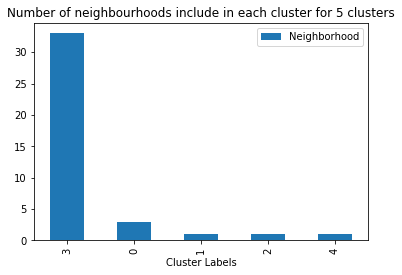

In [40]:
cluster_counts.plot(kind='bar', title='Number of neighbourhoods include in each cluster for {} clusters'.format(kclusters))

### Conclusion for 5 clusters

When we divide neighbourhoods in 5 clusters our result includes 3 outliers of one neighbourhood, one cluster
of two neighbourhoods, and one cluster with all the other neighbourhoods.

Thus, this cluster size helps us to identify outliers, but it shows little in the way of actual 
clusters and their possible characteristics.

### Variation: What happens with other numbers of clusters?

I've set the number of clusters to several values. This mostly resulted in getting one blob of neighbourhoods and a number of outliers.

First at kclusters=10 did I get a split up to larger sized clusters.

In [41]:
kclusters = 10
toronto_merged, cluster_counts = cluster_neighbourhoods(kclusters)
show_clusters(kclusters, toronto_merged)

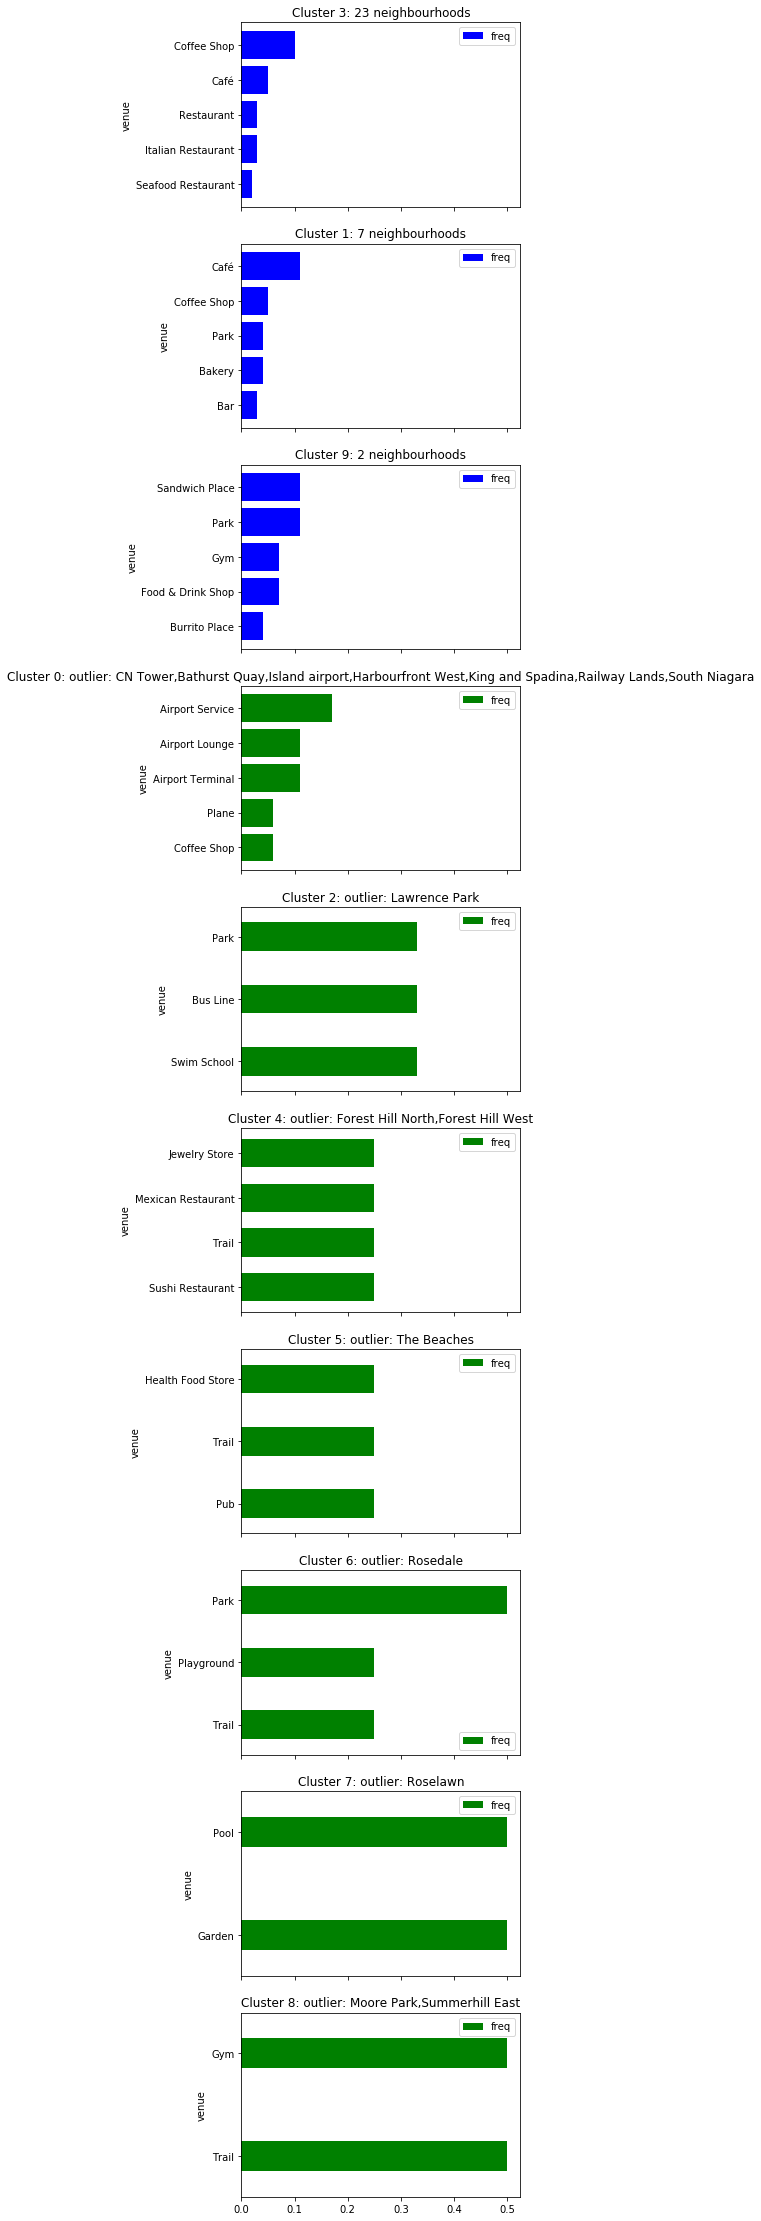

In [42]:
evaluate_clusters(cluster_counts, toronto_onehot, toronto_merged)

Let's visualize the number of neighbourhoods in each cluster.

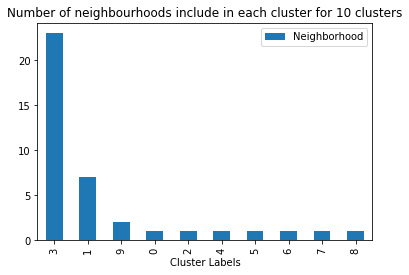

In [43]:
cluster_counts.plot(kind='bar', title='Number of neighbourhoods include in each cluster for {} clusters'.format(kclusters))

### Conclusion for 10 clusters

We now find three largers clusters with respectively 6, 10, and 16 neighbourhoods and 7 outliers.
Five of the outliers contain a park, a sixth a garden.

Looking at the three larger clusters, we find that all of them include a coffeeshop and cafe, with the first two having coffeeshop and cafe in the first and second place. These clusters are not that different.

## Overall conclusion

The Toronto boroughs with 'Toronto' in their name are dominated by coffeeshops and cafes. Based on venues this area comes across as relatively homogenous. 
The neighbourhoods that are outliers typically contain landscape features like a park, a garden, or a playground.